In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys

sys.path.insert(0,'../PROJECT_TO_SUBMIT')
from implementations import *

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Set preprocessing parameters

In [3]:
# Do you want to repace the -999 with zeros?
ReplaceToZero_FLAG = True

# Do you want to remove the highly correlated columns from the datasets
RemoveHCColumns_FLAG = True
CorrelationThreshold = 0.8

# Preprocessing
First, we handle the invalid values.

In [4]:
# Reload the data, the first part had explanatory purposes. Here we want to start from scratch, and to repeat step by step
# the manipulations that we applied 
yb, input_data, ids = load_csv_data("../data/train.csv", sub_sample=False)
print('Train data have been loaded')

# Replace -999 with zeros
if ReplaceToZero_FLAG:
    print('Replacing the invalid values (i.e. -999) with 0.')
    input_data = replaceWithZero(input_data,-999)

Replacing -999 with 0.


Now we are going to divide the dataset in 3 different datasets, according to the number of jets. <br><br>
Since in the new division some columns will have constant values, we will also delete those columns and save the indices in order do the same preprocessing when we want to use our model to predict.
<br><br>
Finally, note that we keep the mean and the std of the train set. These parameters will be used to perform the standardization in the prediction phase

In [5]:
idxs = indices_jet_division(input_data)

x0, x1, x2 = data_split_with_jet_division(input_data,idxs)
y0, y1, y2 = data_split_with_jet_division(yb,idxs)

#only the first 2 subsets have const columns
x0, idx_constants_removed0 = removeConstantColumns(x0)
x1, idx_constants_removed1 = removeConstantColumns(x1)


x0, mean_train0, std_train0 = standardize ( x0 )
x1, mean_train1, std_train1 = standardize ( x1 )
x2, mean_train2, std_train2 = standardize ( x2 )

We are left with dealing with the correlated columns.

In [6]:
if RemoveHCColumns_FLAG:
    print('Removing highly correlated columns.')
    x0, idx_HC_removed0 = removeHighCorrelatedColumns(x0, CorrelationThreshold)
    x1, idx_HC_removed1 = removeHighCorrelatedColumns(x1, CorrelationThreshold)
    x2, idx_HC_removed2 = removeHighCorrelatedColumns(x2, CorrelationThreshold)
else:
    idx_HC_removed0 = []
    idx_HC_removed0 = []
    idx_HC_removed0 = []

Removing highly correlated columns.


# Training
Grid search to find the best degree and the best lambda.
<br><br>
For each couple (lambda, degree) we trained the model using <b>ridge regression with 4-fold cross validation</b>. Since this is not a classifier, the goodness of the model is evaluated using the mean of the 4 accuracies (i.e. the percentage of correct predictions) on the validations set of the cross validation.

In [17]:
degrees0 = np.arange(8,15)
lambdas0 = np.linspace(1e-7,0.0001,25) 

degrees1 = np.arange(8,15)
lambdas1 = np.linspace(1e-5,0.0001,25) 

degrees2 = np.arange(10,17)
lambdas2 = np.linspace(1e-5,0.01,25) 

best_lambda_acc0, best_degree_acc0, accuracy0 = grid_search_hyperparam_with_RidgeCV(y0, x0, lambdas0, degrees0)

best_lambda_acc1, best_degree_acc1, accuracy1 = grid_search_hyperparam_with_RidgeCV(y1, x1, lambdas1, degrees1)

best_lambda_acc2, best_degree_acc2, accuracy2 = grid_search_hyperparam_with_RidgeCV(y2, x2, lambdas2, degrees2)


print('Training results:')
print(f'Model with 0 jets:  lambda = {best_lambda_acc0}, degree = {best_degree_acc0}, accuracy = {np.max(accuracy0)}')
print(f'Model with 1 jets:  lambda = {best_lambda_acc1}, degree = {best_degree_acc1}, accuracy = {np.max(accuracy1)}')
print(f'Model with >1 jets: lambda = {best_lambda_acc2}, degree = {best_degree_acc2}, accuracy = {np.max(accuracy2)}')


N0 = x0.shape[0]
N1 = x1.shape[0]
N2 = x2.shape[0]

#This is a good estimate of the goodness of our model
TOTAccuracy = ( N0*np.max(accuracy0) + N1*np.max(accuracy1) + N2*np.max(accuracy2) ) / ( N0 + N1 + N2 )
print(f'\n\nOur validation set reached a global accuracy of {TOTAccuracy}')

Training results:
Model with 0 jets:  lambda = [7.08625e-05], degree = [12], accuracy = 0.8434322203539115
Model with 1 jets:  lambda = [6.625e-05], degree = [12], accuracy = 0.8055039719385123
Model with >1 jets: lambda = [0.0008425], degree = [14], accuracy = 0.8307003032809486


Our validation set reached a global accuracy of 0.8279733421325208


In [18]:
# Recompute best weights using the hyperparameters and the full train (sub)sets
x0_augmented = build_poly(x0, int(best_degree_acc0[0]))
best_w_acc0,_ = ridge_regression(y0,x0_augmented,best_lambda_acc0[0])

x1_augmented = build_poly(x1, int(best_degree_acc1[0]))
best_w_acc1,_ = ridge_regression(y1,x1_augmented,best_lambda_acc1[0])

x2_augmented = build_poly(x2, int(best_degree_acc2[0]))
best_w_acc2,_ = ridge_regression(y2,x2_augmented,best_lambda_acc2[0])

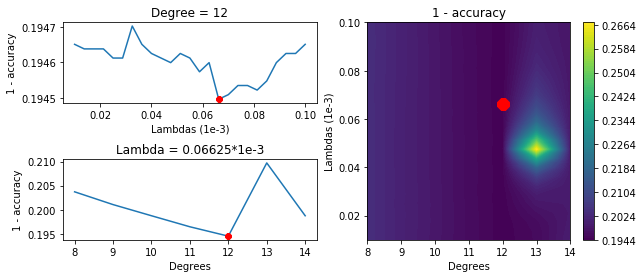

In [42]:
plot_grid_search(lambdas1, degrees1, accuracy1, 'grid_search.eps')

# Submission

In [19]:
_, test_data, ids_test = load_csv_data("../data/test.csv", sub_sample=False)
num_tests = test_data.shape[0]

We need to repeat the same manipulations applied on the train set also on the test set.

In [20]:
# handle invalid data
if ReplaceToZero_FLAG:
    print('Replacing -999 with 0.')
    test_data = replaceWithZero(test_data,-999)

    
# jets division
idxsTest = indices_jet_division(test_data)
x0Test, x1Test, x2Test = data_split_with_jet_division(test_data,idxsTest)

# remove const. columns
x0Test = np.delete(x0Test, idx_constants_removed0, axis=1)
x1Test = np.delete(x1Test, idx_constants_removed1, axis=1)


# standardization with train parameters
x0Test,_,_ = standardize ( x0Test, mean_train0, std_train0 )
x1Test,_,_ = standardize ( x1Test, mean_train1, std_train1 )
x2Test,_,_ = standardize ( x2Test, mean_train2, std_train2 )

# removing higly correlated columns
if(RemoveHCColumns_FLAG):
    print('Removing highly correlated columns.')
    for i in idx_HC_removed0:
        x0Test = np.delete(x0Test,i,axis=1)
    for i in idx_HC_removed1:
        x1Test = np.delete(x1Test,i,axis=1)
    for i in idx_HC_removed2:
        x2Test = np.delete(x2Test,i,axis=1)

Replacing -999 with 0.
Removing highly correlated columns.


Now we need to use the results of the regression to make the prediction

In [21]:
# augment the feature according to the best degree
x0Test = build_poly(x0Test, int(best_degree_acc0[0]))
x1Test = build_poly(x1Test, int(best_degree_acc1[0]))
x2Test = build_poly(x2Test, int(best_degree_acc2[0]))

# for each subset, predict its output
y_pred0 = predict_labels(best_w_acc0,x0Test)
y_pred1 = predict_labels(best_w_acc1,x1Test)
y_pred2 = predict_labels(best_w_acc2,x2Test)

# recompose the whole predicion
y_pred = np.ones(num_tests)
y_pred[idxsTest[0]] = y_pred0
y_pred[idxsTest[1]] = y_pred1
y_pred[idxsTest[2]] = y_pred2

In [22]:
create_csv_submission(ids_test, y_pred, 'FinalModel_WithoutHCColumns.csv')